In [1]:
# !pip install vaderSentiment
# !pip install textstat
# !pip install pickle
# !pip install joblib
import pandas as pd
import numpy as np
import pickle
import joblib
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline





## Loading the data

In [2]:
# df = pd.read_csv("E:\lenovo\Documents\Jupyterstuff\gp2\labeled_data.csv") Put own path or use colab under
df = pd.read_csv("labeled_data.csv")

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [5]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


<Axes: >

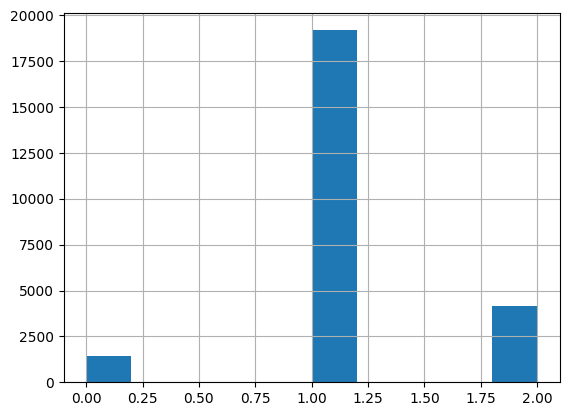

In [6]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [7]:
tweets=df.tweet

In [8]:
# This section consisted of the basic stuff, reading the file, using describe on the data to find out the "statistics" of each column
# Then we declared the 3 classes we will work on, 0 for hate, 1 for offensive, 2 for neither.
# This histogram shows the imbalanced nature of the task,
# most tweets containing "hate" words as defined by Hatebase were only considered to be offensive by the CF coders.
# More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.


## Feature generation

In [9]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\win 10\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\win
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()
# """ Stemming is a text normalization technique that cuts off the end or beginning of a word by taking into account
# a list of common prefixes or suffixes that could be found in that word """ "returns words to their root"


def preprocess(text_string):
    # """
    # Accepts a text string and replaces:
    # 1) urls with URLHERE
    # 2) lots of whitespace with one instance
    # 3) mentions with MENTIONHERE

    # This allows us to get standardized counts of urls and mentions
    # Without caring about specific people mentioned
    # """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    # """Removes punctuation & excess whitespace, sets to lowercase,
    # and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    # """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

#TFIDF VECTORIZER
# It can be defined as the calculation of how relevant a word in a series or corpus is to a text.
# The meaning increases proportionally to the number of times in the text a word appears
# but is compensated by the word frequency in the corpus (data-set).

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#This just ignores future warnings

In [12]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

C:\Users\win 10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\win 10\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [13]:
#Breaking down last cell
# print(vectorizer.fit_transform(tweets))
# transforms the tweets into a sparse matrix representation
# where each row represents a tweet and each column represents a unique word in the entire collection of tweets.

print(vectorizer.fit_transform(tweets).toarray())
# This converts the sparse matrix representation into a dense NumPy array.
# The resulting tfidf array contains the TF-IDF values for each word in each tweet.

# Vocab is a dictionary where keys are unique words in the entire collection of tweets (retrieved using vectorizer.get_feature_names_out())
# and values are their corresponding indices in the TF-IDF matrix.

[[1.29163073 0.         0.         ... 0.         0.         0.        ]
 [2.58326146 0.         0.         ... 0.         0.         0.        ]
 [2.58326146 0.         0.         ... 0.         0.         0.        ]
 ...
 [1.29163073 0.         0.         ... 0.         0.         0.        ]
 [1.29163073 0.         0.         ... 0.         0.         0.        ]
 [2.58326146 0.         0.         ... 0.         0.         0.        ]]


In [14]:
#Get POS tags for tweets and save as a string

tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

# The for loop processes a collection of tweets, tokenizes and preprocesses each tweet,
# assigns part-of-speech tags to the tokens, and then stores the sequences of part-of-speech tags for each tweet in a list called tweet_tags.
#POS tagging, it uses grammer stuff like nouns and verbs adjactives for each word because it helps in understanding the syntax structure.

In [15]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [16]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

#Last two cells are the same as the previous tfidf method, were making a tokens matrix for POS tags this time
#then making a tfidf matrix and then getting the vocab dictionary, all for pos.

In [17]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    # """ function just for statistics
    # Accepts a text string and replaces:
    # 1) urls with URLHERE
    # 2) lots of whitespace with one instance
    # 3) mentions with MENTIONHERE
    # 4) hashtags with HASHTAGHERE

    # This allows us to get standardized counts of urls and mentions
    # Without caring about specific people mentioned.

    # Returns counts of urls, mentions, and hashtags.
    # """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    # """This function takes a string and returns a list of features.
    # These include Sentiment scores, Text and Readability scores,
    # as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [18]:
# It calculates sentiment scores using a sentiment analyzer. (negative, positive, neutral)
# Then,it preprocesses the tweet to extract text-only content and computes various metrics such as syllable count,
# character count, word count, average syllables per word, and number of unique terms.

# Then it calculates modified versions of Flesch-Kincaid Readability (FKRA) and Flesch Reading Ease (FRE) scores tailored for tweets. "How easy the data is to read"
# It also identifies Twitter-specific features like mentions, hashtags, and URLs.

# Then it constructs a list containing all these features and returns it.
# This function is useful for extracting meaningful information from tweets for tasks such as sentiment analysis,
# readability assessment, and Twitter-specific analysis.

In [19]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [20]:
feats = get_feature_array(tweets)

In [21]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [22]:
M.shape

(24783, 4023)

In [23]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

The best model was selected using a GridSearch with 5-fold CV.

In [24]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [27]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   #for data visualization and graphical plotting
from matplotlib import style      #for styling the plot
style.use("ggplot")

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
from nltk.corpus import stopwords            #to filterout useless data
stopword = set(stopwords.words('english'))

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import re
import string


In [28]:
# svm = SVC()

# # Fit the model to the training data
# svm.fit(X_train, y_train)

# # Predict on the test data
# svm_pred = svm.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, svm_pred)
# print("Test accuracy:", accuracy)
svm = joblib.load("HateSpeechSVCfit.pkl")
# Predict on the test data
svm_pred = svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, svm_pred)
print("Test accuracy:", accuracy)

Test accuracy: 0.7975790181573639


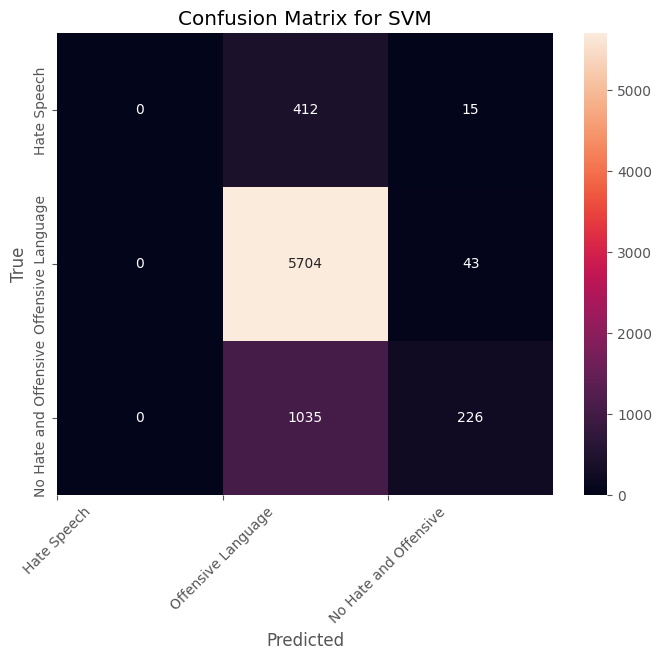

In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, svm_pred)

# Define labels for the axes
labels = ['Hate Speech', 'Offensive Language', 'No Hate and Offensive']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for SVM")
plt.xticks(ticks=[0, 1, 2], labels=labels, rotation=45)
plt.show()

In [ ]:
# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}


grid = GridSearchCV(svm, param_grid, cv=5)
grid.fit(X_train, y_train)

In [ ]:
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

svm_hyper_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, svm_hyper_pred)
print("Test accuracy:", accuracy)



In [ ]:
joblib.dump(grid, 'HateSpeechSVM84_6CV2.pkl')

## Evaluating the results

In [ ]:
report = classification_report( y_test, y_preds )

***Note: Results in paper are from best model retrained on the entire dataset (see the other notebook). Here the results are reported after using cross-validation and only for the held-out set.***

In [ ]:
print(report)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# Basic Confusion matrix

In [ ]:
#True distribution
y.hist()

In [ ]:
pd.Series(y_preds).hist()

In [ ]:
#Saving the Model
joblib.dump(model, 'HateSpeechSVM81.pkl')
# joblib.load("HateSpeechTestrun_Model.pkl")